/Users/2_kumi/Desktop/무제 폴더/complex_xi.py:261: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


▶ Saving results to cp4_30_3_2.2results.xlsx…
✔ Results saved successfully!
Mean phase difference: 0.3144 rad
⋯ echo-wise 5-column 시각화 생성


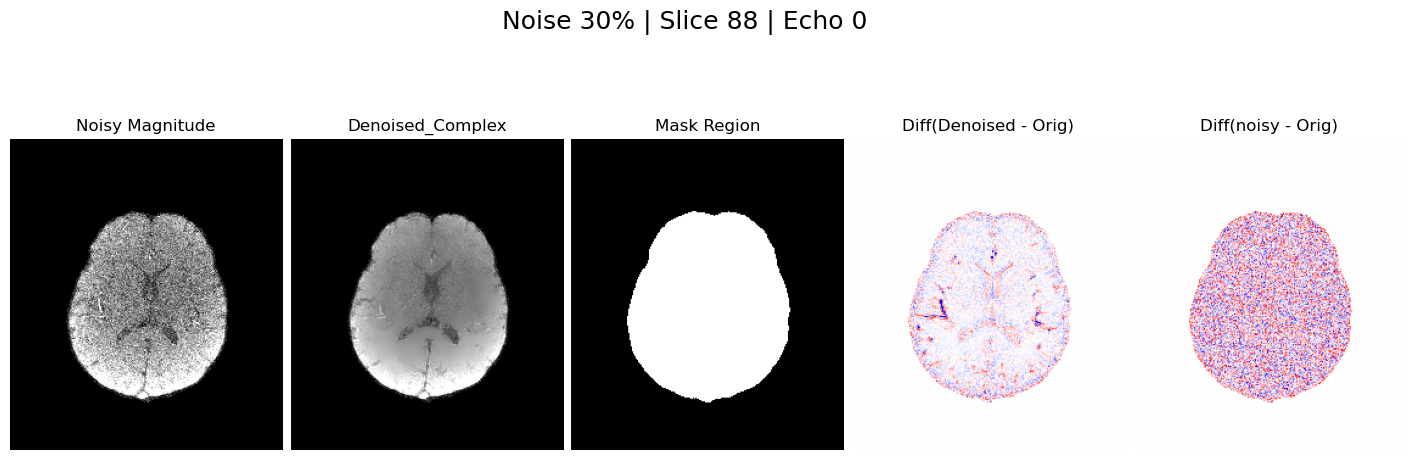

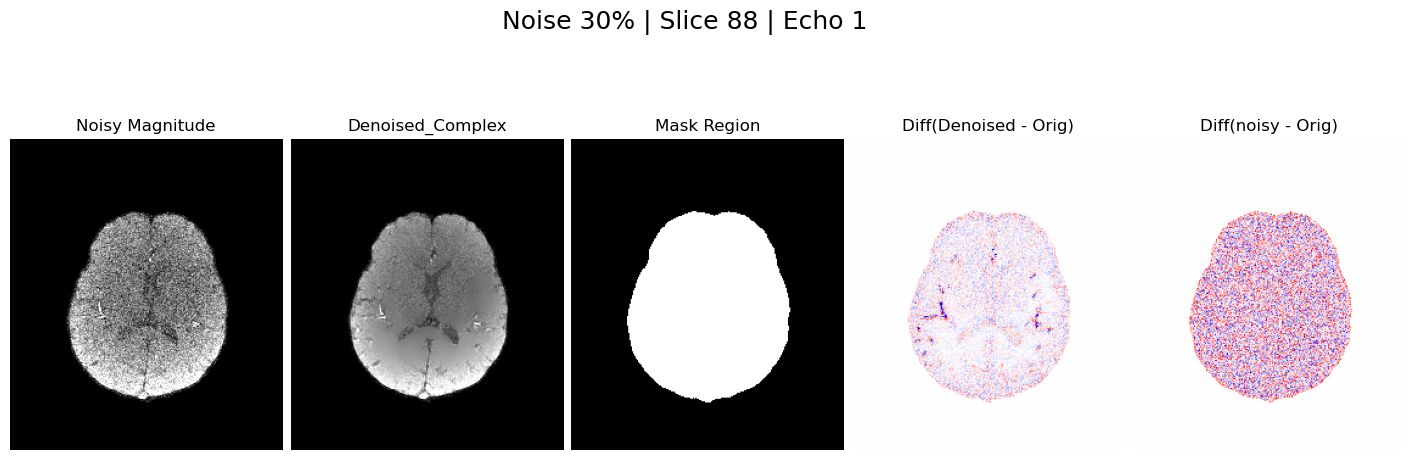

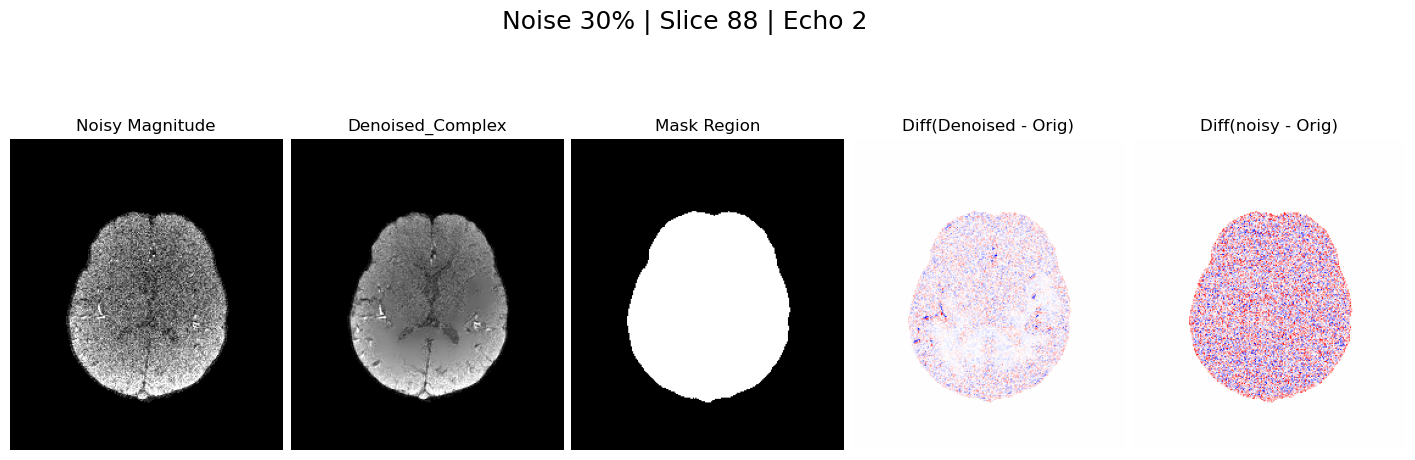

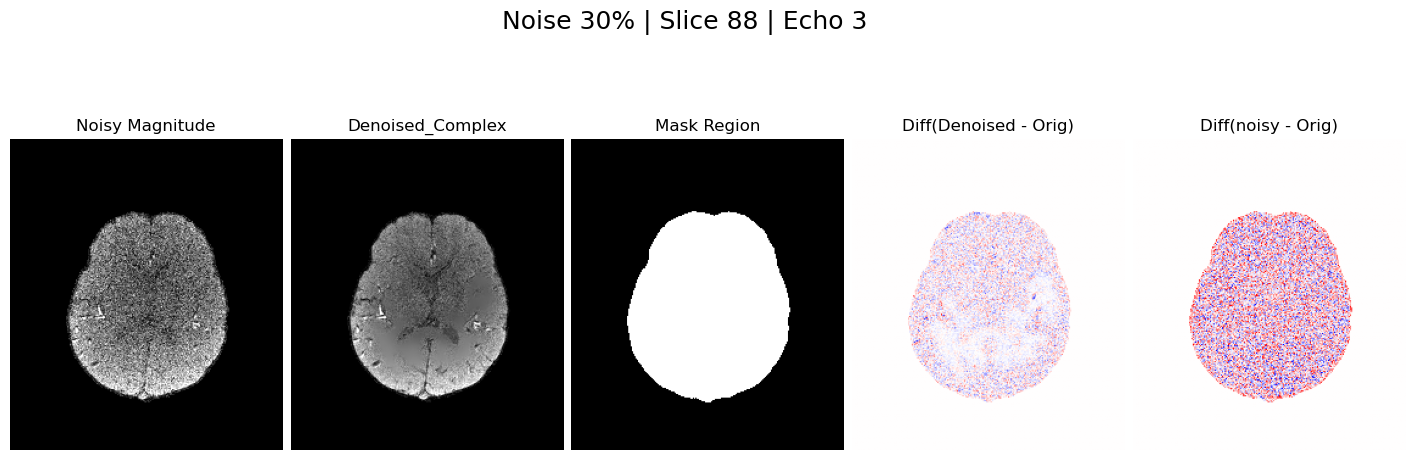

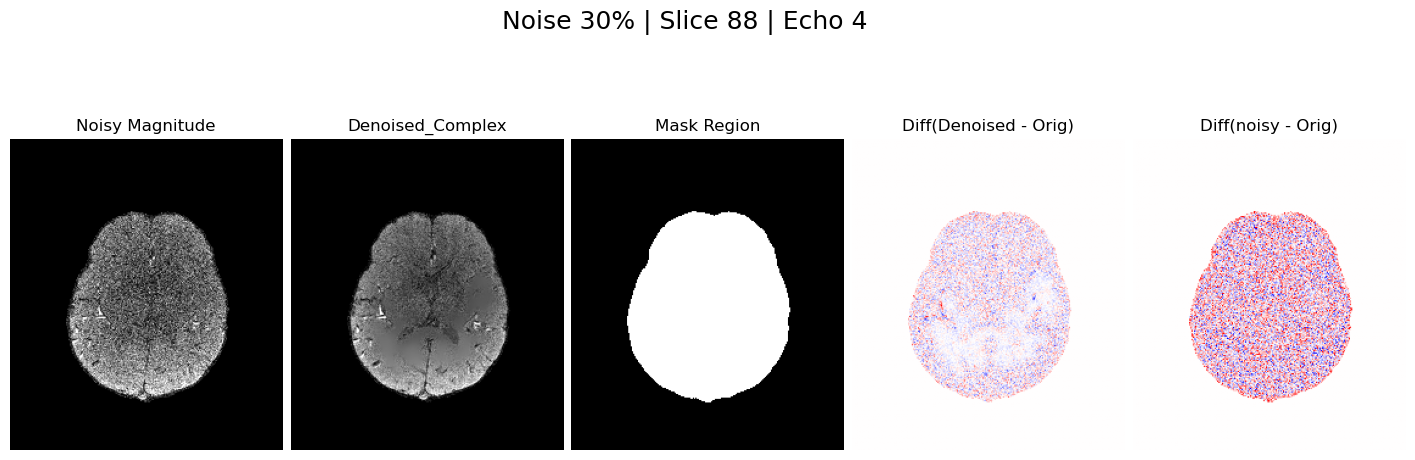

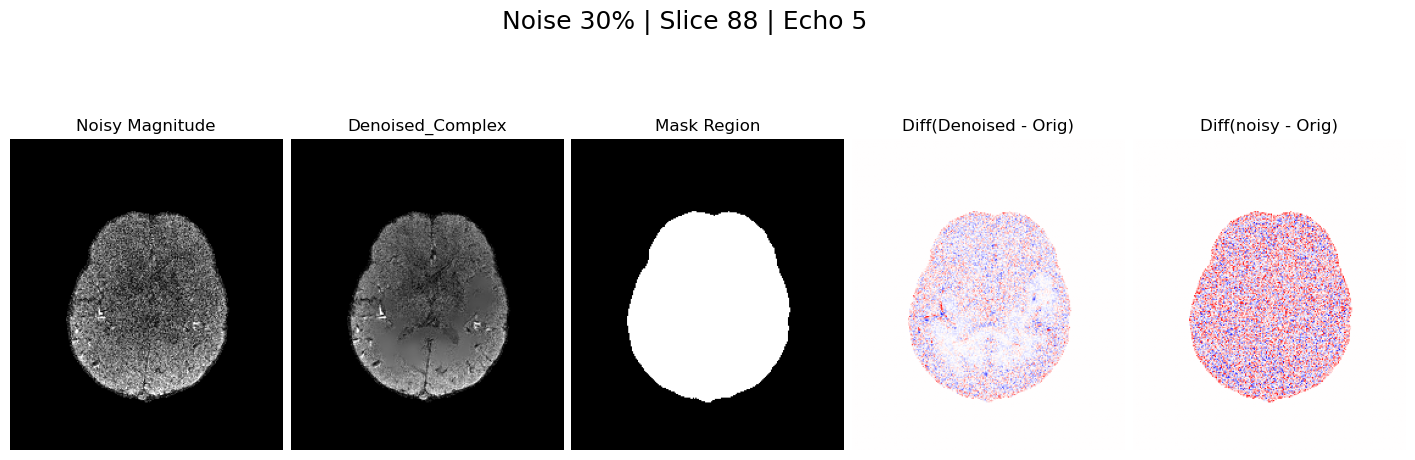

In [1]:
import numpy as np
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import pandas as pd
from complex_xi import mppca
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

# ----------------------- Parameters -----------------------
PATCH_RADIUS = 3         # 패치 반경 (7×7×7)
EPSILON      = 1e-12     # SNR 계산 시 0으로 나누기 방지
SLICE_IDX    = None      # None이면 중앙 슬라이스 (Z//2) 사용

# ----------------------- Load data -----------------------
orig_mat    = sio.loadmat('meas_gre_dir1.mat')
meas_gre    = orig_mat['meas_gre']                     # (X, Y, Z, Ne), complex
mask_brain  = orig_mat['mask_brain'].astype(bool)      # (X, Y, Z), bool

noise_mat   = sio.loadmat('noisy_meas_gre_dir1_30.mat')
noisy_real  = noise_mat['noisy_real'].astype(np.float32)
noisy_imag  = noise_mat['noisy_imag'].astype(np.float32)

# ----------------------- Setup dims & slice -----------------------
X, Y, Z, Ne = meas_gre.shape
if SLICE_IDX is None:
    SLICE_IDX = Z // 2

# ----------------------- Compute magnitudes -----------------------
mag_orig  = np.abs(orig_mat["meas_gre"]).astype(np.float32)
mag_noisy = np.sqrt(noisy_real**2 + noisy_imag**2)

# ----------------------- Denoise via MP-PCA -----------------------
noisy_complex = (noisy_real + 1j * noisy_imag).astype(np.complex64)
denoised = mppca(
    noisy_complex,
    mask=mask_brain,
    patch_radius=PATCH_RADIUS,
    pca_method='svd',
    return_sigma=False
)
mag_den_cmplx = np.abs(denoised)


# ----------------------- Bias-corrected SNR functions -----------------------
def snr_diff_rician(ref, test, roi):
    s = []
    for c in range(ref.shape[3]):
        mu        = ref[..., c][roi].mean()
        sigma_raw = (test[..., c] - ref[..., c])[roi].std(ddof=1)
        s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
        s.append(s_corr / (sigma_raw + EPSILON) * np.sqrt(2))
    return np.asarray(s)

# Echo-wise
snr_noisy_bc = snr_diff_rician(mag_orig,  mag_noisy,  mask_brain)
snr_cmplx_bc = snr_diff_rician(mag_orig,  mag_den_cmplx, mask_brain)

df_echo_bc = pd.DataFrame({
    'Echo':           np.arange(Ne),
    'SNR_Noisy_BC':   snr_noisy_bc,
    'SNR_Complex_BC': snr_cmplx_bc,
    'ΔSNR_Complex':   snr_cmplx_bc - snr_noisy_bc
}).round(3)

# 평균 행 추가
avg = {
    'Echo':           'Average',
    'SNR_Noisy_BC':   df_echo_bc['SNR_Noisy_BC'].mean(),
    'SNR_Complex_BC': df_echo_bc['SNR_Complex_BC'].mean(),
    'ΔSNR_Complex':   df_echo_bc['ΔSNR_Complex'].mean()
}
df_echo_bc = pd.concat([df_echo_bc, pd.DataFrame([avg])], ignore_index=True)

# Slice-wise
def snr_slice_df_bc(ref, test, roi, label):
    rows = []
    Xdim, Ydim, Zdim, C = ref.shape
    for z in range(Zdim):
        mask2d = roi[:, :, z]
        if not mask2d.any(): continue
        for c in range(C):
            mu        = ref[:, :, z, c][mask2d].mean()
            sigma_raw = (test[:, :, z, c] - ref[:, :, z, c])[mask2d].std(ddof=1)
            s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
            snr_val   = s_corr / (sigma_raw + EPSILON) * np.sqrt(2)
            rows.append({'Slice': z, 'Echo': c, label: round(snr_val, 3)})
    return pd.DataFrame(rows)

df_snr_noisy = snr_slice_df_bc(mag_orig,  mag_noisy,    mask_brain, 'SNR_Noisy_BC')
df_snr_cmplx = snr_slice_df_bc(mag_orig,  mag_den_cmplx, mask_brain, 'SNR_Complex_BC')

df_slice_all = (
    df_snr_noisy
    .merge(df_snr_cmplx, on=['Slice','Echo'])
    .sort_values(['Echo','Slice'], ignore_index=True)
)

# ----------------------- Save to Excel -----------------------
excel_filename = 'cp4_30_3_2.2results.xlsx'
print(f'▶ Saving results to {excel_filename}…')
with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
    df_slice_all.to_excel(writer, sheet_name='Slice_by_Echo', index=False)
    df_echo_bc.to_excel(writer,   sheet_name='Echo_Summary',  index=False)
print('✔ Results saved successfully!')

# Phase 차이 확인 (복소수 디노이징의 장점)
phase_orig = np.angle(meas_gre)
phase_denoised = np.angle(denoised)
phase_diff = np.abs(phase_orig - phase_denoised)
print(f"Mean phase difference: {np.mean(phase_diff[mask_brain]):.4f} rad")

# ----------------------- Visualization -----------------------
vmin, vmax = np.percentile(mag_orig[mask_brain], (1, 99))

print("⋯ echo-wise 5-column 시각화 생성")
n_echoes = mag_orig.shape[-1]
diff_vmax = np.percentile(
    np.abs(mag_noisy - mag_orig)[mask_brain], 99)  # diff 컬러범위 고정

for e in range(Ne):
    fig, axes = plt.subplots(1, 5, figsize=(18,6))
    fig.suptitle(f"Noise 30% | Slice {SLICE_IDX} | Echo {e}", fontsize=18)

    axes[0].imshow(mag_noisy[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Noisy Magnitude');      axes[0].axis('off')

    axes[1].imshow(mag_den_cmplx[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Denoised_Complex');  axes[1].axis('off')

    axes[2].imshow(mask_brain[:, :, SLICE_IDX], cmap='gray')
    axes[2].set_title('Mask Region');  axes[2].axis('off')

    diff = mag_den_cmplx[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[3].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[3].set_title('Diff(Denoised - Orig)');      axes[3].axis('off')

    diff = mag_noisy[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[4].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[4].set_title('Diff(noisy - Orig)');      axes[4].axis('off')

    plt.subplots_adjust(wspace=0.03, hspace=0.1, top=0.9)
    plt.show()

/Users/2_kumi/Desktop/무제 폴더/complex_iii.py:208: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


▶ Saving results to cp3_10_3results.xlsx…
✔ Results saved successfully!
Mean phase difference: 0.1814 rad
⋯ echo-wise 5-column 시각화 생성


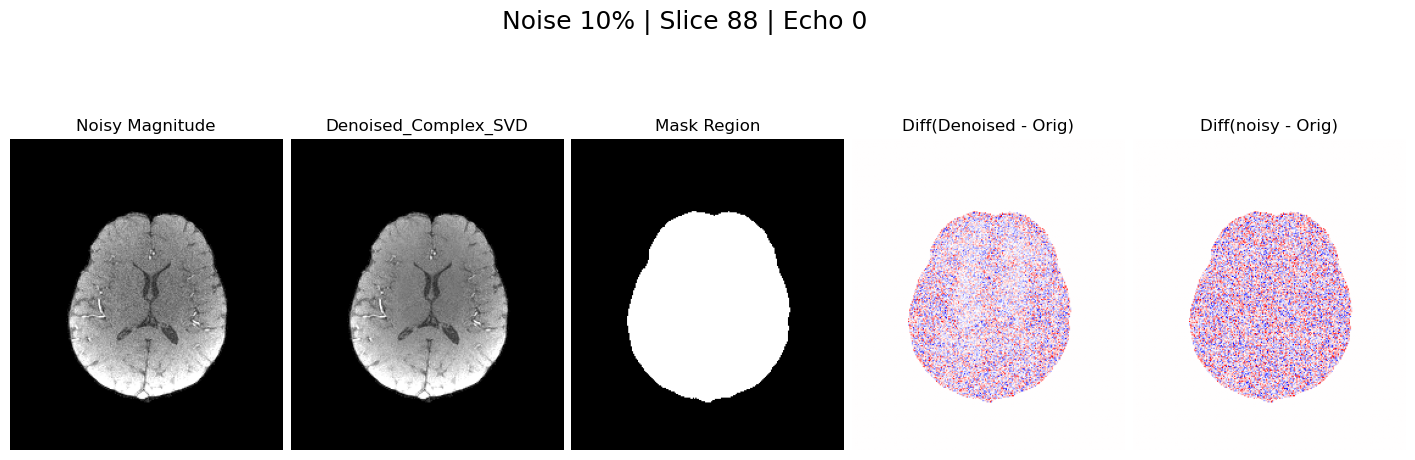

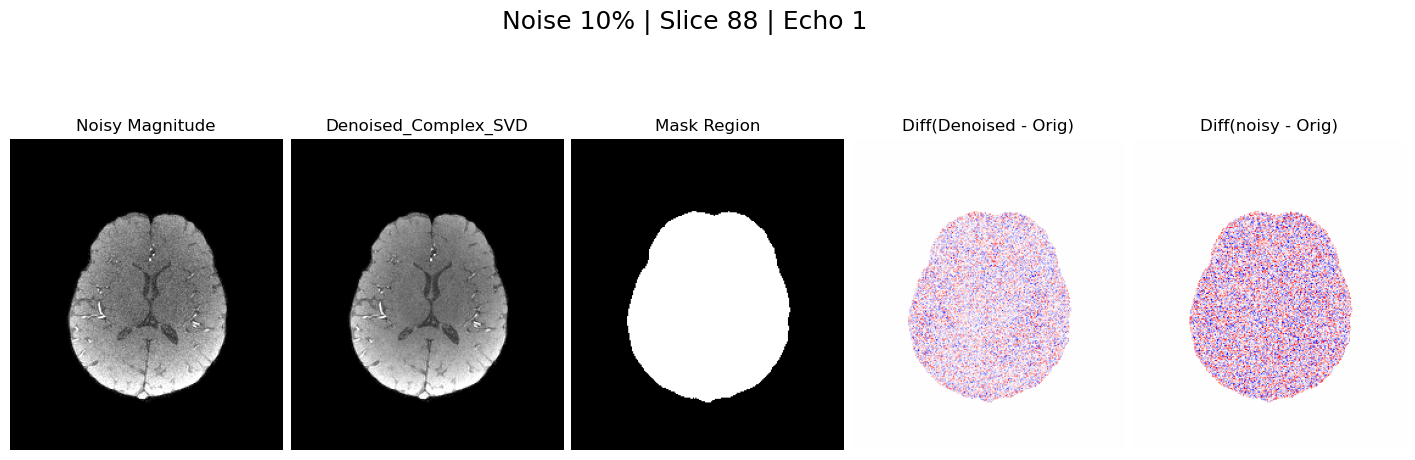

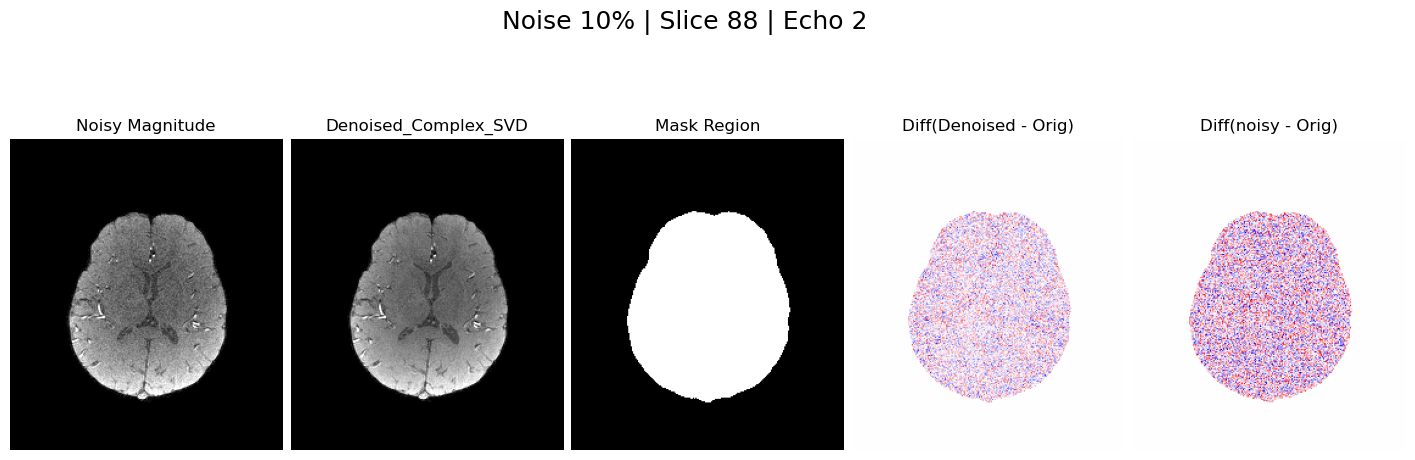

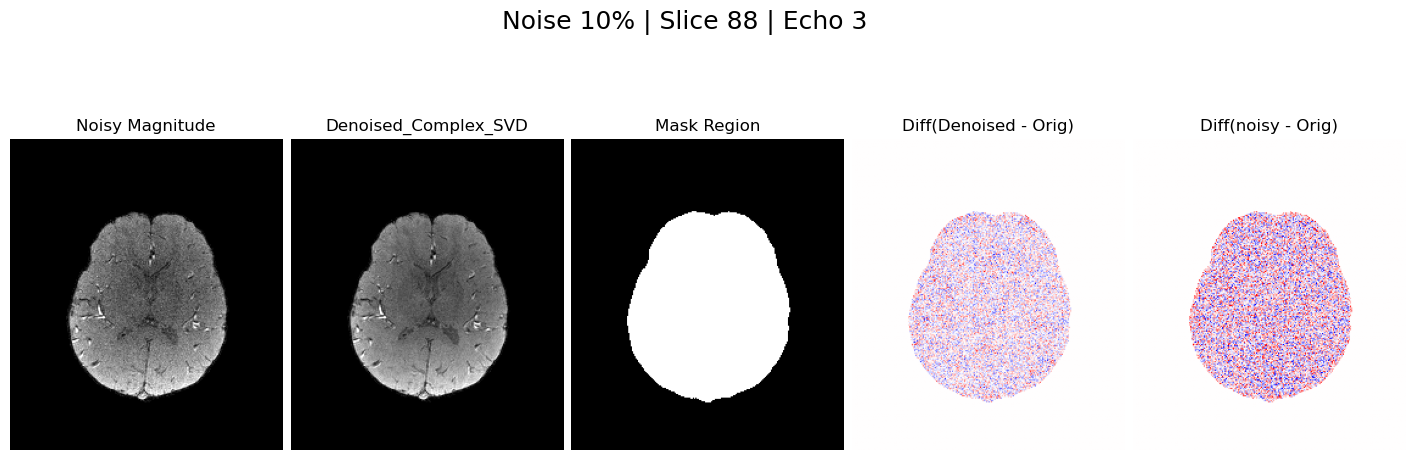

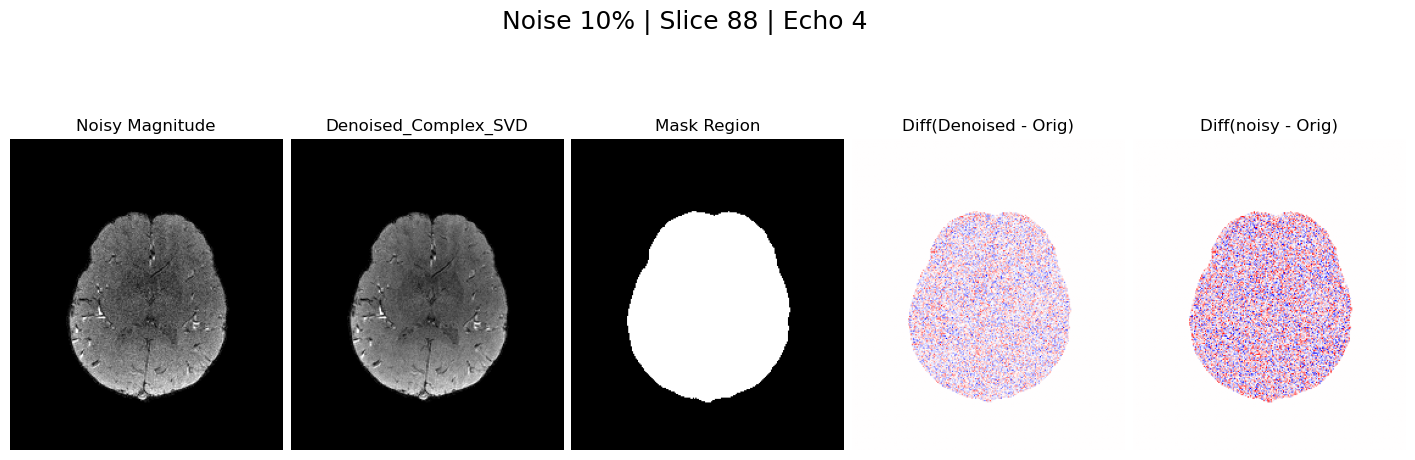

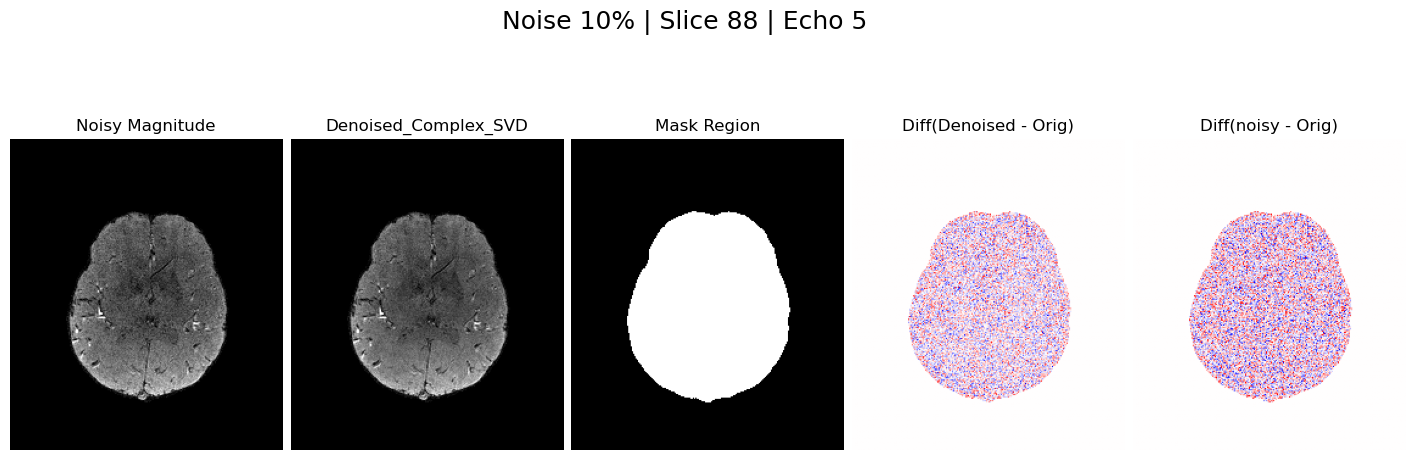

In [3]:
import numpy as np
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import pandas as pd
from complex_iii import mppca
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

# ----------------------- Parameters -----------------------
PATCH_RADIUS = 3         # 패치 반경 (7×7×7)
EPSILON      = 1e-12     # SNR 계산 시 0으로 나누기 방지
SLICE_IDX    = None      # None이면 중앙 슬라이스 (Z//2) 사용

# ----------------------- Load data -----------------------
orig_mat    = sio.loadmat('meas_gre_dir1.mat')
meas_gre    = orig_mat['meas_gre']                     # (X, Y, Z, Ne), complex
mask_brain  = orig_mat['mask_brain'].astype(bool)      # (X, Y, Z), bool

noise_mat   = sio.loadmat('noisy_meas_gre_dir1_10.mat')
noisy_real  = noise_mat['noisy_real'].astype(np.float32)
noisy_imag  = noise_mat['noisy_imag'].astype(np.float32)

# ----------------------- Setup dims & slice -----------------------
X, Y, Z, Ne = meas_gre.shape
if SLICE_IDX is None:
    SLICE_IDX = Z // 2

# ----------------------- Compute magnitudes -----------------------
mag_orig  = np.abs(orig_mat["meas_gre"]).astype(np.float32)
mag_noisy = np.sqrt(noisy_real**2 + noisy_imag**2)

# ----------------------- Denoise via MP-PCA -----------------------
noisy_complex = noisy_real + 1j * noisy_imag
denoised = mppca(
    noisy_complex,
    mask=mask_brain,
    patch_radius=PATCH_RADIUS,
    pca_method='svd',
    return_sigma=False
)
mag_den_cmplx = np.abs(denoised)


# ----------------------- Bias-corrected SNR functions -----------------------
def snr_diff_rician(ref, test, roi):
    s = []
    for c in range(ref.shape[3]):
        mu        = ref[..., c][roi].mean()
        sigma_raw = (test[..., c] - ref[..., c])[roi].std(ddof=1)
        s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
        s.append(s_corr / (sigma_raw + EPSILON) * np.sqrt(2))
    return np.asarray(s)

# Echo-wise
snr_noisy_bc = snr_diff_rician(mag_orig,  mag_noisy,  mask_brain)
snr_cmplx_bc = snr_diff_rician(mag_orig,  mag_den_cmplx, mask_brain)

df_echo_bc = pd.DataFrame({
    'Echo':           np.arange(Ne),
    'SNR_Noisy_BC':   snr_noisy_bc,
    'SNR_Complex_BC': snr_cmplx_bc,
    'ΔSNR_Complex':   snr_cmplx_bc - snr_noisy_bc
}).round(3)

# 평균 행 추가
avg = {
    'Echo':           'Average',
    'SNR_Noisy_BC':   df_echo_bc['SNR_Noisy_BC'].mean(),
    'SNR_Complex_BC': df_echo_bc['SNR_Complex_BC'].mean(),
    'ΔSNR_Complex':   df_echo_bc['ΔSNR_Complex'].mean()
}
df_echo_bc = pd.concat([df_echo_bc, pd.DataFrame([avg])], ignore_index=True)

# Slice-wise
def snr_slice_df_bc(ref, test, roi, label):
    rows = []
    Xdim, Ydim, Zdim, C = ref.shape
    for z in range(Zdim):
        mask2d = roi[:, :, z]
        if not mask2d.any(): continue
        for c in range(C):
            mu        = ref[:, :, z, c][mask2d].mean()
            sigma_raw = (test[:, :, z, c] - ref[:, :, z, c])[mask2d].std(ddof=1)
            s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
            snr_val   = s_corr / (sigma_raw + EPSILON) * np.sqrt(2)
            rows.append({'Slice': z, 'Echo': c, label: round(snr_val, 3)})
    return pd.DataFrame(rows)

df_snr_noisy = snr_slice_df_bc(mag_orig,  mag_noisy,    mask_brain, 'SNR_Noisy_BC')
df_snr_cmplx = snr_slice_df_bc(mag_orig,  mag_den_cmplx, mask_brain, 'SNR_Complex_BC')

df_slice_all = (
    df_snr_noisy
    .merge(df_snr_cmplx, on=['Slice','Echo'])
    .sort_values(['Echo','Slice'], ignore_index=True)
)

# ----------------------- Save to Excel -----------------------
excel_filename = 'cp3_10_3results.xlsx'
print(f'▶ Saving results to {excel_filename}…')
with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
    df_slice_all.to_excel(writer, sheet_name='Slice_by_Echo', index=False)
    df_echo_bc.to_excel(writer,   sheet_name='Echo_Summary',  index=False)
print('✔ Results saved successfully!')

# Phase 차이 확인 (복소수 디노이징의 장점)
phase_orig = np.angle(meas_gre)
phase_denoised = np.angle(denoised)
phase_diff = np.abs(phase_orig - phase_denoised)
print(f"Mean phase difference: {np.mean(phase_diff[mask_brain]):.4f} rad")


# ----------------------- Visualization -----------------------
vmin, vmax = np.percentile(mag_orig[mask_brain], (1, 99))

print("⋯ echo-wise 5-column 시각화 생성")
n_echoes = mag_orig.shape[-1]
diff_vmax = np.percentile(
    np.abs(mag_noisy - mag_orig)[mask_brain], 99)  # diff 컬러범위 고정

for e in range(Ne):
    fig, axes = plt.subplots(1, 5, figsize=(18,6))
    fig.suptitle(f"Noise 10% | Slice {SLICE_IDX} | Echo {e}", fontsize=18)

    axes[0].imshow(mag_noisy[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Noisy Magnitude');      axes[0].axis('off')

    axes[1].imshow(mag_den_cmplx[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Denoised_Complex_SVD');  axes[1].axis('off')

    axes[2].imshow(mask_brain[:, :, SLICE_IDX], cmap='gray')
    axes[2].set_title('Mask Region');  axes[2].axis('off')

    diff = mag_den_cmplx[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[3].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[3].set_title('Diff(Denoised - Orig)');      axes[3].axis('off')

    diff = mag_noisy[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[4].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[4].set_title('Diff(noisy - Orig)');      axes[4].axis('off')

    plt.subplots_adjust(wspace=0.03, hspace=0.1, top=0.9)
    plt.show()

/Users/2_kumi/Desktop/무제 폴더/complex_iii.py:208: RuntimeWarning: invalid value encountered in divide
  denoised_arr = thetax / theta
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


▶ Saving results to cp3_50_3results.xlsx…
✔ Results saved successfully!
Mean phase difference: 0.5422 rad
⋯ echo-wise 5-column 시각화 생성


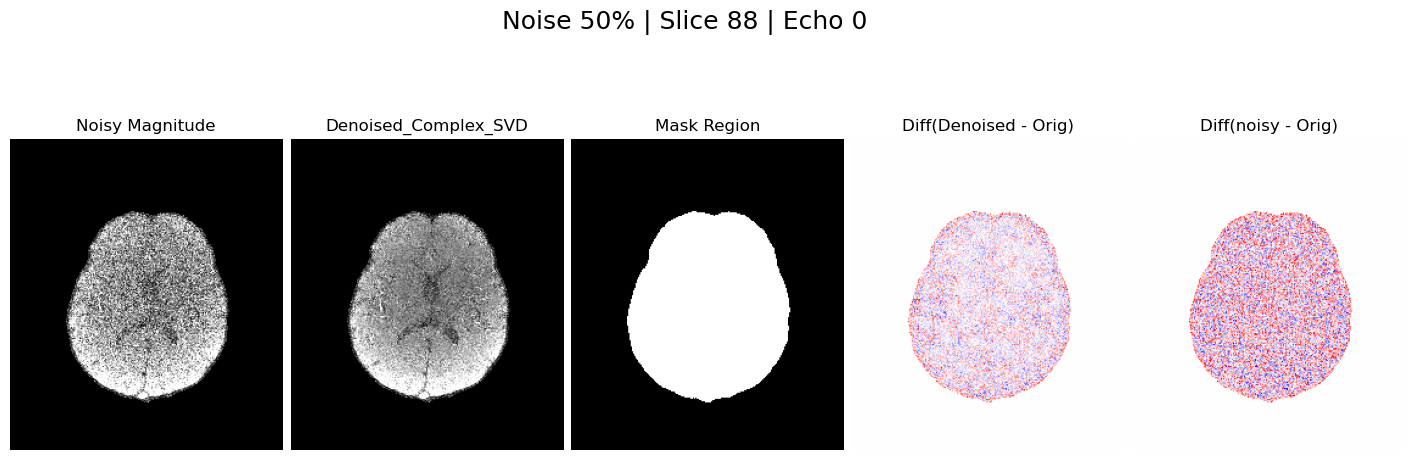

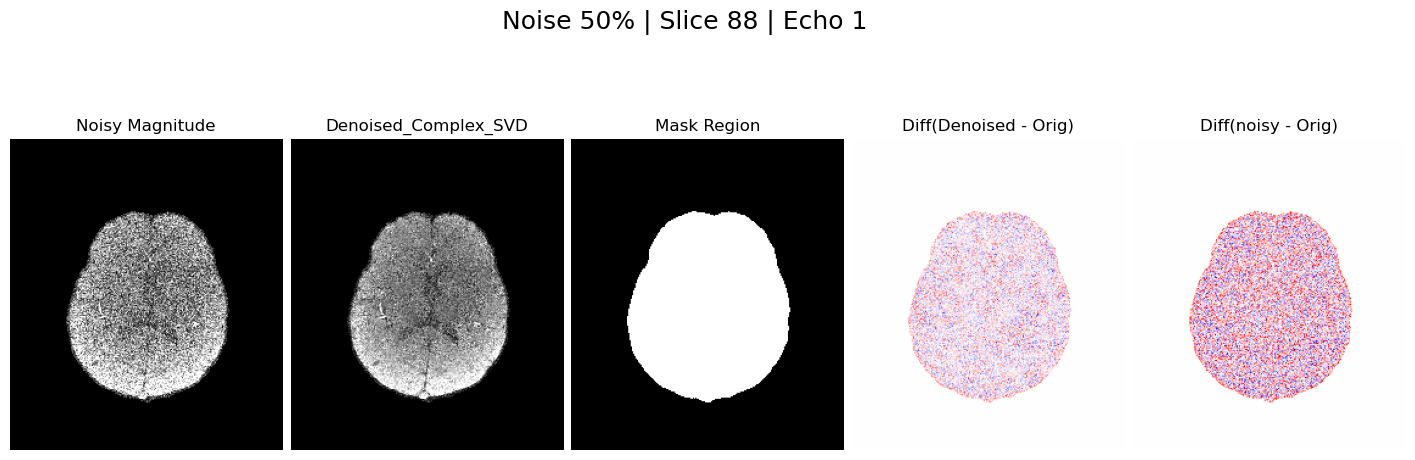

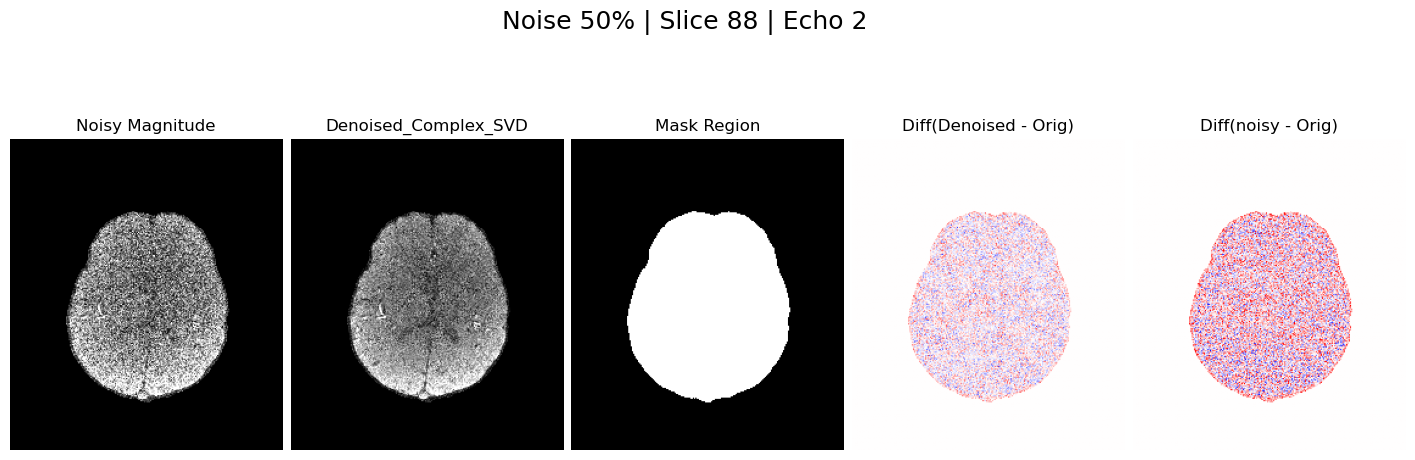

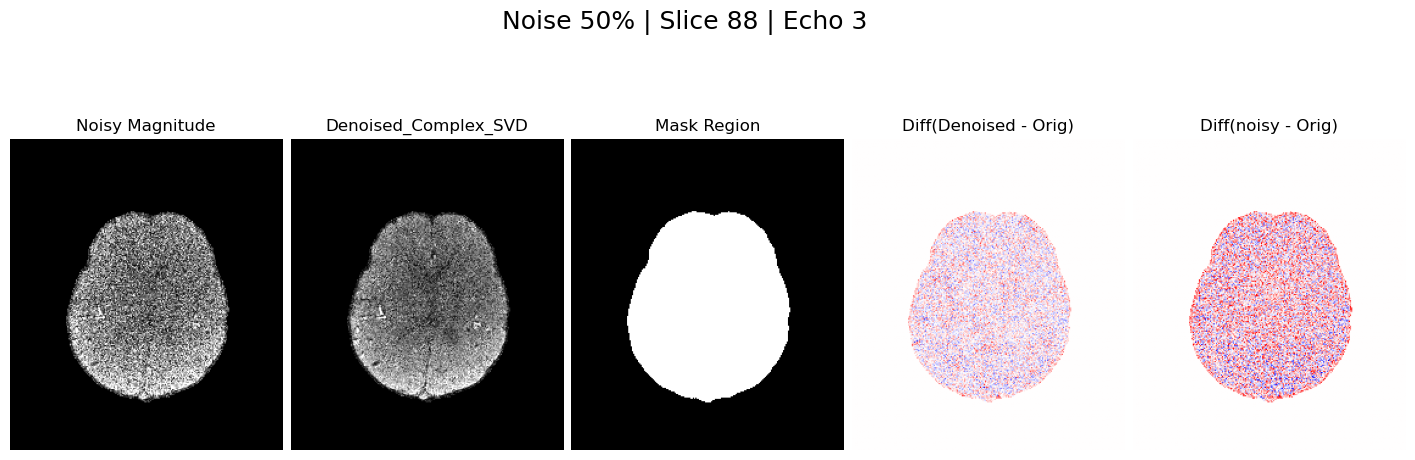

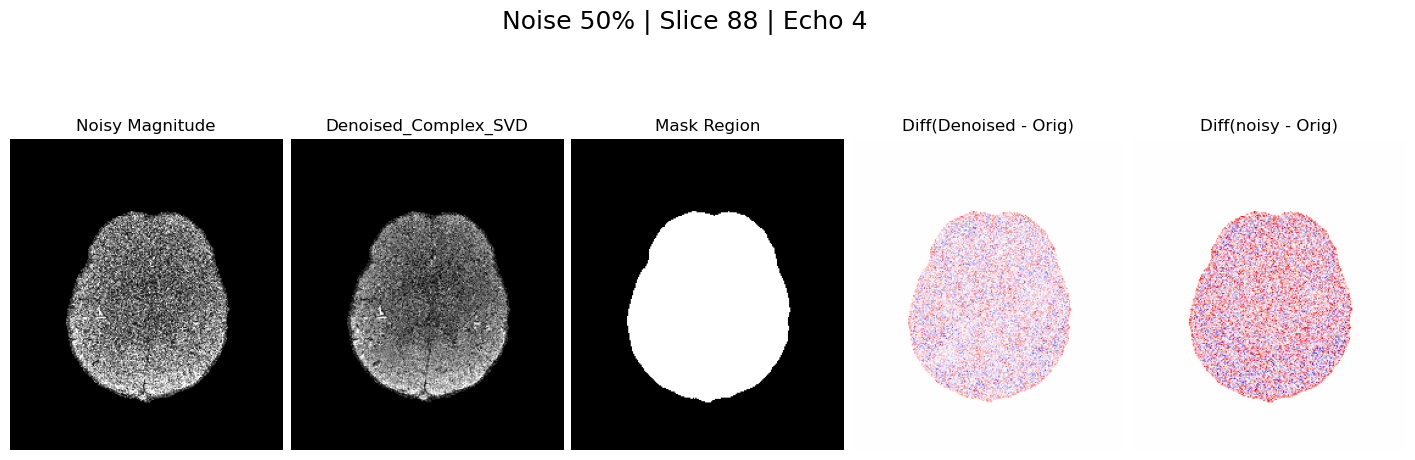

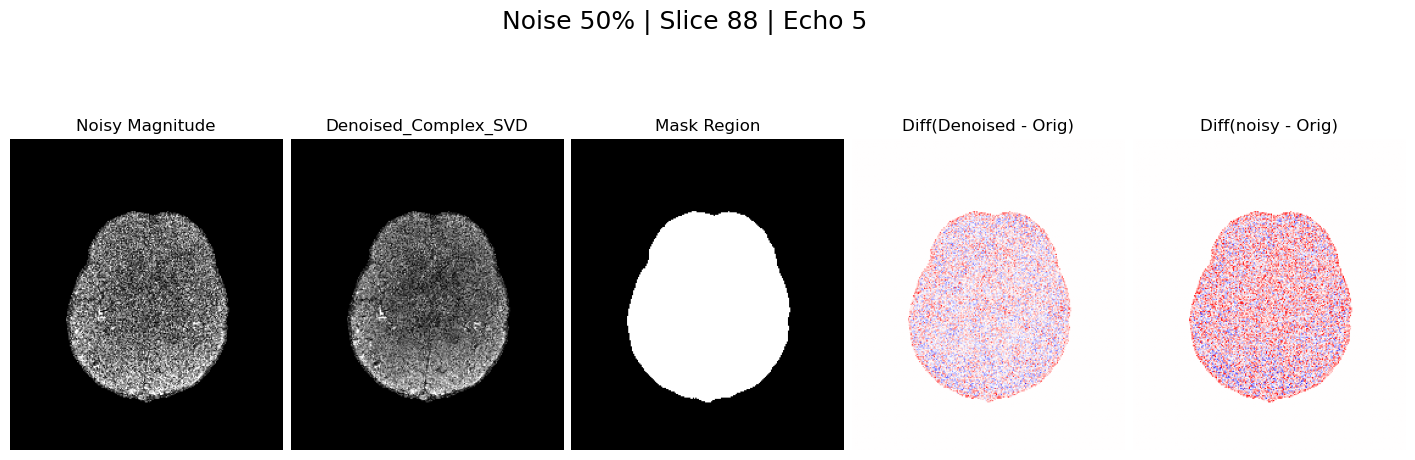

In [4]:
import numpy as np
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import pandas as pd
from complex_iii import mppca
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

# ----------------------- Parameters -----------------------
PATCH_RADIUS = 3         # 패치 반경 (7×7×7)
EPSILON      = 1e-12     # SNR 계산 시 0으로 나누기 방지
SLICE_IDX    = None      # None이면 중앙 슬라이스 (Z//2) 사용

# ----------------------- Load data -----------------------
orig_mat    = sio.loadmat('meas_gre_dir1.mat')
meas_gre    = orig_mat['meas_gre']                     # (X, Y, Z, Ne), complex
mask_brain  = orig_mat['mask_brain'].astype(bool)      # (X, Y, Z), bool

noise_mat   = sio.loadmat('noisy_meas_gre_dir1_50.mat')
noisy_real  = noise_mat['noisy_real'].astype(np.float32)
noisy_imag  = noise_mat['noisy_imag'].astype(np.float32)

# ----------------------- Setup dims & slice -----------------------
X, Y, Z, Ne = meas_gre.shape
if SLICE_IDX is None:
    SLICE_IDX = Z // 2

# ----------------------- Compute magnitudes -----------------------
mag_orig  = np.abs(orig_mat["meas_gre"]).astype(np.float32)
mag_noisy = np.sqrt(noisy_real**2 + noisy_imag**2)

# ----------------------- Denoise via MP-PCA -----------------------
noisy_complex = noisy_real + 1j * noisy_imag
denoised = mppca(
    noisy_complex,
    mask=mask_brain,
    patch_radius=PATCH_RADIUS,
    pca_method='svd',
    return_sigma=False
)
mag_den_cmplx = np.abs(denoised)


# ----------------------- Bias-corrected SNR functions -----------------------
def snr_diff_rician(ref, test, roi):
    s = []
    for c in range(ref.shape[3]):
        mu        = ref[..., c][roi].mean()
        sigma_raw = (test[..., c] - ref[..., c])[roi].std(ddof=1)
        s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
        s.append(s_corr / (sigma_raw + EPSILON) * np.sqrt(2))
    return np.asarray(s)

# Echo-wise
snr_noisy_bc = snr_diff_rician(mag_orig,  mag_noisy,  mask_brain)
snr_cmplx_bc = snr_diff_rician(mag_orig,  mag_den_cmplx, mask_brain)

df_echo_bc = pd.DataFrame({
    'Echo':           np.arange(Ne),
    'SNR_Noisy_BC':   snr_noisy_bc,
    'SNR_Complex_BC': snr_cmplx_bc,
    'ΔSNR_Complex':   snr_cmplx_bc - snr_noisy_bc
}).round(3)

# 평균 행 추가
avg = {
    'Echo':           'Average',
    'SNR_Noisy_BC':   df_echo_bc['SNR_Noisy_BC'].mean(),
    'SNR_Complex_BC': df_echo_bc['SNR_Complex_BC'].mean(),
    'ΔSNR_Complex':   df_echo_bc['ΔSNR_Complex'].mean()
}
df_echo_bc = pd.concat([df_echo_bc, pd.DataFrame([avg])], ignore_index=True)

# Slice-wise
def snr_slice_df_bc(ref, test, roi, label):
    rows = []
    Xdim, Ydim, Zdim, C = ref.shape
    for z in range(Zdim):
        mask2d = roi[:, :, z]
        if not mask2d.any(): continue
        for c in range(C):
            mu        = ref[:, :, z, c][mask2d].mean()
            sigma_raw = (test[:, :, z, c] - ref[:, :, z, c])[mask2d].std(ddof=1)
            s_corr    = np.sqrt(max(mu**2 - 2 * sigma_raw**2, 0.0))
            snr_val   = s_corr / (sigma_raw + EPSILON) * np.sqrt(2)
            rows.append({'Slice': z, 'Echo': c, label: round(snr_val, 3)})
    return pd.DataFrame(rows)

df_snr_noisy = snr_slice_df_bc(mag_orig,  mag_noisy,    mask_brain, 'SNR_Noisy_BC')
df_snr_cmplx = snr_slice_df_bc(mag_orig,  mag_den_cmplx, mask_brain, 'SNR_Complex_BC')

df_slice_all = (
    df_snr_noisy
    .merge(df_snr_cmplx, on=['Slice','Echo'])
    .sort_values(['Echo','Slice'], ignore_index=True)
)

# ----------------------- Save to Excel -----------------------
excel_filename = 'cp3_50_3results.xlsx'
print(f'▶ Saving results to {excel_filename}…')
with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
    df_slice_all.to_excel(writer, sheet_name='Slice_by_Echo', index=False)
    df_echo_bc.to_excel(writer,   sheet_name='Echo_Summary',  index=False)
print('✔ Results saved successfully!')

# Phase 차이 확인 (복소수 디노이징의 장점)
phase_orig = np.angle(meas_gre)
phase_denoised = np.angle(denoised)
phase_diff = np.abs(phase_orig - phase_denoised)
print(f"Mean phase difference: {np.mean(phase_diff[mask_brain]):.4f} rad")


# ----------------------- Visualization -----------------------
vmin, vmax = np.percentile(mag_orig[mask_brain], (1, 99))

print("⋯ echo-wise 5-column 시각화 생성")
n_echoes = mag_orig.shape[-1]
diff_vmax = np.percentile(
    np.abs(mag_noisy - mag_orig)[mask_brain], 99)  # diff 컬러범위 고정

for e in range(Ne):
    fig, axes = plt.subplots(1, 5, figsize=(18,6))
    fig.suptitle(f"Noise 50% | Slice {SLICE_IDX} | Echo {e}", fontsize=18)

    axes[0].imshow(mag_noisy[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Noisy Magnitude');      axes[0].axis('off')

    axes[1].imshow(mag_den_cmplx[:, :, SLICE_IDX, e], cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Denoised_Complex_SVD');  axes[1].axis('off')

    axes[2].imshow(mask_brain[:, :, SLICE_IDX], cmap='gray')
    axes[2].set_title('Mask Region');  axes[2].axis('off')

    diff = mag_den_cmplx[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[3].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[3].set_title('Diff(Denoised - Orig)');      axes[3].axis('off')

    diff = mag_noisy[:, :, SLICE_IDX, e] - mag_orig[:, :, SLICE_IDX, e]
    axes[4].imshow(diff, cmap='bwr', vmin=-diff_vmax, vmax=diff_vmax)
    axes[4].set_title('Diff(noisy - Orig)');      axes[4].axis('off')

    plt.subplots_adjust(wspace=0.03, hspace=0.1, top=0.9)
    plt.show()